In [29]:
import pandas as pd
import numpy as np
np.set_printoptions(threshold=np.inf)

# Classification

### Logistic Regression

In [30]:
class MultinomialLogisticRegression:
    def __init__(self, learning_rate=0.1, num_epochs=10000):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs

    def set_hyperparameters(self, learning_rate, num_epochs):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs

    def softmax(self, z):
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def cross_entropy_loss(self, X, y):
        z = np.dot(X, self.weights.T) + self.bias
        y_pred = self.softmax(z)
        m = y_pred.shape[0]
        return -np.sum(np.log(y_pred) * y)/m

    def gradient_descent(self, X, y):
        m = X.shape[0]
        for epoch in range(self.num_epochs):
            z = np.dot(X, self.weights.T) + self.bias
            y_pred = self.softmax(z)
            loss = self.cross_entropy_loss(X, y)
            dw = np.dot((y_pred - y).T, X)/m
            db = np.sum(y_pred - y, axis=0)/m
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            # print(loss)

    def fit(self, X, y):
        num_classes = y.shape[1]
        num_features = X.shape[1]
        self.weights = np.zeros((num_classes, num_features))
        self.bias = np.zeros(num_classes)
        self.gradient_descent(X, y)

    def predict(self, X):
        z = np.dot(X, self.weights.T) + self.bias
        max_values = np.max(z, axis=1, keepdims=True)
        y_pred = (z == max_values).astype(int)
        return y_pred
    
    def predict_proba(self,X):
        z = np.dot(X, self.weights.T) + self.bias
        return z

### MLP Classifier

In [31]:
class MLPClassifier(object):
    def __init__(self, inputLayerSize=2, hiddenLayers=1, hiddenLayerSize=3, outputLayerSize=1,acivationFunction="sigmoid",number_epoch=1000,learning_rate=0.001,optimizer="gd"):
        self.inputLayerSize = inputLayerSize
        self.outputLayerSize = outputLayerSize
        self.hiddenLayers = hiddenLayers
        self.hiddenLayerSize = hiddenLayerSize
        self.activationFunction=acivationFunction
        self.number_epoch=number_epoch
        self.learning_rate=learning_rate
        self.optimizer=optimizer

    def initialize(self):
        self.weights=[]
        self.biases=[]
        self.weights.append(np.random.randn(self.inputLayerSize, self.hiddenLayerSize))
        self.biases.append(np.random.randn(self.hiddenLayerSize))
        for i in range(self.hiddenLayers-1):
            self.weights.append(np.random.randn(self.hiddenLayerSize, self.hiddenLayerSize))
            self.biases.append(np.random.randn(self.hiddenLayerSize))
        self.weights.append(np.random.randn(self.hiddenLayerSize, self.outputLayerSize))
        self.biases.append(np.random.randn(self.outputLayerSize))

    def fit(self,X,y):
        if self.optimizer=="gd":
            self.gd(X,y)
        if self.optimizer=="mini_gd":
            self.mini_gd(X,y)
        if self.optimizer=="sgd":
            self.sgd(X,y)

    def softmax(self, z):
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)
    
    def activation(self,z):
        if(self.activationFunction=='sigmoid'):
            return 1 / (1 + np.exp(-z))
        if(self.activationFunction=='relu'):
            return np.maximum(0, z)
        if(self.activationFunction=='tanh'):
            return np.tanh(z)
    
    def activationPrime(self,z):    
        if(self.activationFunction=='sigmoid'):
            return np.exp(-z)/((1 + np.exp(-z))**2)
        if(self.activationFunction=='relu'):
            return (z > 0).astype(int)
        if(self.activationFunction=='tanh'):
            return 1 - np.tanh(z) ** 2

    def forward(self, X):
        self.z=[]
        self.a=[]
        self.z.append(np.dot(X,self.weights[0])+self.biases[0])
        self.a.append(self.activation(self.z[0]))
        for i in range(1,self.hiddenLayers):
            self.z.append(np.dot(self.a[i-1],self.weights[i])+self.biases[i])
            self.a.append(self.activation(self.z[i]))
        self.z.append(np.dot(self.a[self.hiddenLayers-1],self.weights[self.hiddenLayers])+self.biases[self.hiddenLayers])
        self.a.append(self.softmax(self.z[self.hiddenLayers]))
        yHat=self.a[self.hiddenLayers]
        return yHat
    
    def predict(self, X):
        yHat=self.forward(X)
        max_values = np.max(yHat, axis=1, keepdims=True)
        y_pred = (yHat == max_values).astype(int)
        return y_pred
    
    def predict_proba(self,X):
        yHat=self.forward(X)
        return yHat

    def backward(self,X,y):
        m=len(X)
        yHat=self.forward(X)
        self.delta=[]
        self.gradient_weight=[]
        self.gradient_bias=[]
        self.delta.append(-(y-yHat)/m)
        self.gradient_weight.append(np.dot(self.a[self.hiddenLayers-1].T,self.delta[-1]))
        self.gradient_bias.append(np.sum(self.delta[-1],axis=0))
        for i in range(self.hiddenLayers-1,0,-1):
            delta_i=np.dot(self.delta[-1],self.weights[i+1].T)*self.activationPrime(self.z[i])/m
            self.delta.append(delta_i)
            self.gradient_weight.append(np.dot(self.a[i-1].T,delta_i))
            self.gradient_bias.append(np.sum(self.delta[-1],axis=0))
        delta_i=np.dot(self.delta[-1],self.weights[1].T)*self.activationPrime(self.z[0])/m
        self.delta.append(delta_i)
        self.gradient_weight.append(np.dot(X.T,delta_i))
        self.gradient_bias.append(np.sum(self.delta[-1],axis=0))
        self.gradient_weight.reverse()
        self.gradient_bias.reverse()

    def loss(self, y_pred, y_true):
        m=len(y_pred)
        return -np.sum(np.log(y_pred) * y_true)/m

    def gd(self,X,y):
        self.initialize()
        for i in range (self.number_epoch):
            # print(self.loss(self.forward(X),y))
            self.backward(X,y)
            for j in range(len(self.weights)):
                self.weights[j]-=self.learning_rate*self.gradient_weight[j]
                self.biases[j]-=self.learning_rate*self.gradient_bias[j]

    def mini_gd(self,X,y):
        self.initialize()
        batch_size=32
        batches=len(X)//batch_size
        for epoch in range(self.number_epoch):
            for i in range(0,batches,batch_size):
                self.backward(X[i:i+batch_size],y[i:i+batch_size])
                for k in range(len(self.weights)):
                    self.weights[k]-=self.learning_rate*self.gradient_weight[k]
                    self.biases[k]-=self.learning_rate*self.gradient_bias[k]
            # print(self.loss(self.forward(X),y))

    def sgd(self,X,y):
        self.initialize()
        for j in range(self.number_epoch):
            for i in range(len(X)):
                self.backward(X[i:i+1],y[i:i+1])
                for k in range(len(self.weights)):
                    self.weights[k]-=self.learning_rate*self.gradient_weight[k]
                    self.biases[k]-=self.learning_rate*self.gradient_bias[k]
            # print(self.loss(self.forward(X),y))


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.metrics import accuracy_score

### Data Processing

In [33]:
wine_data = pd.read_csv('WineQT.csv')

X= wine_data.drop(columns=['quality','Id'])
y=wine_data['quality']
y = pd.get_dummies(y, columns=['quality']).astype(int)
X=X.to_numpy()
y=y.to_numpy()

X_train_cl, X_temp_cl, y_train_cl, y_temp_cl = train_test_split(X, y, test_size=0.2)
X_val_cl, X_test_cl, y_val_cl, y_test_cl = train_test_split(X_temp_cl, y_temp_cl, test_size=0.5)


scaler = StandardScaler()
X_train_cl = scaler.fit_transform(X_train_cl)
X_val_cl = scaler.transform(X_val_cl)
X_test_cl = scaler.transform(X_test_cl)

In [34]:
model = MultinomialLogisticRegression(0.01,1000)
model.fit(X_train_cl, y_train_cl)

y_pred = model.predict(X_test_cl)
print('Loss :',model.cross_entropy_loss(X_train_cl,y_train_cl))
print('Accuracy :',accuracy_score(y_test_cl, y_pred))

Loss : 1.0115610370862789
Accuracy : 0.6173913043478261


In [35]:
model = MLPClassifier(11,2,10,6,acivationFunction="relu",number_epoch=100,learning_rate=0.001,optimizer="sgd")
model.fit(X_train_cl,y_train_cl)

y_pred=model.predict(X_train_cl)
print(accuracy_score(y_train_cl, y_pred))

y_pred=model.predict(X_test_cl)
print(accuracy_score(y_test_cl, y_pred))

0.6531728665207878
0.5565217391304348


In [36]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion='entropy',max_depth=30)
clf.fit(X_train_cl, y_train_cl)
y_pred = clf.predict(X_test_cl)

accuracy = accuracy_score(y_test_cl, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.5478260869565217


### Hyperparameter Tuning for DecisionTreeClassifier

In [37]:
criteria=['gini','entropy']
depth=[10,20,30]

best_criterion_dt_cl=""
best_depth_dt_cl=""
best_accuracy_dt=0

for c in criteria:
    for d in depth:
        model = DecisionTreeClassifier(criterion=c,max_depth=d)
        model.fit(X_train_cl, y_train_cl)
        y_pred = model.predict(X_test_cl)
        accuracy = accuracy_score(y_test_cl, y_pred)
        if accuracy>best_accuracy_dt:
            best_criterion_dt_cl=c
            best_depth_dt_cl=d
            best_accuracy_dt=accuracy

print(best_criterion_dt_cl,best_depth_dt_cl,best_accuracy_dt)

entropy 30 0.591304347826087


In [38]:
lg_cl_model=MultinomialLogisticRegression(0.01,10000)
mlp_cl_model=MLPClassifier(11,2,10,6,acivationFunction="relu",number_epoch=100,learning_rate=0.001,optimizer="sgd")
dt_cl_model=DecisionTreeClassifier(criterion=best_criterion_dt_cl,max_depth=best_depth_dt_cl)

## BaggingClassifier

In [39]:
class BaggingClassifier:
    def __init__(self, base_estimator_model, n_estimators, sample_fraction, bootstrap=True, voting='hard'):
        self.base_estimator_model = base_estimator_model
        self.n_estimators = n_estimators
        self.sample_fraction = sample_fraction
        self.bootstrap = bootstrap
        self.voting = voting
        self.ensemble_models = []

    def fit(self, X, y):
        self.ensemble_models = []
        for i in range(self.n_estimators):
            if self.bootstrap:
                indices = np.random.choice(len(X), size=int(self.sample_fraction * len(X)), replace=True)
            else:
                indices = np.random.choice(len(X), size=int(self.sample_fraction * len(X)), replace=False)
            
            sampled_X = X[indices]
            sampled_y = y[indices]

            if(self.base_estimator_model=='DecisionTree'):
                model = DecisionTreeClassifier(criterion=best_criterion_dt_cl,max_depth=best_depth_dt_cl)
            if(self.base_estimator_model=='MultiLayerPerceptron'):
                model = MLPClassifier(11,2,10,6,acivationFunction="relu",number_epoch=100,learning_rate=0.001,optimizer="sgd")
            if(self.base_estimator_model=='LogisticRegression'):
                model = MultinomialLogisticRegression(0.01,10000)

            model.fit(sampled_X, sampled_y)
            self.ensemble_models.append(model)

    def predict(self, X):
        if self.voting == 'hard':
            predictions = np.array([model.predict(X) for model in self.ensemble_models])
            reshaped_array = predictions.reshape(predictions.shape[0], -1)
            most_frequent_values = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=reshaped_array)
            result = most_frequent_values.reshape(predictions.shape[1],predictions.shape[2])
            return result
        elif self.voting == 'soft':
            weights = np.array([model.predict_proba(X) for model in self.ensemble_models])
            if(self.base_estimator_model=='DecisionTree'):
                weights = np.array([accuracy_score(y_val_cl,model.predict(X_val_cl)) for model in self.ensemble_models])
            weights/=np.sum(weights)
            predictions = np.array([self.ensemble_models[i].predict(X)*weights[i] for i in range(len(self.ensemble_models))])
            mean_probabilities = np.mean(predictions, axis=0)
            max_values = np.max(mean_probabilities, axis=1, keepdims=True)
            y_pred = (mean_probabilities == max_values).astype(int)
            return y_pred

In [40]:
n_estimators = 10
sample_fraction = 0.15
bootstrap = True
voting = 'soft'

bagging_classifier = BaggingClassifier('DecisionTree', n_estimators, sample_fraction, bootstrap, voting)
bagging_classifier.fit(X_train_cl, y_train_cl)
predictions = bagging_classifier.predict(X_test_cl)
print(accuracy_score(y_test_cl,predictions))

0.6


### Hyperparameter Tuning for BaggingClassifier

In [41]:
from prettytable import PrettyTable
import time

base_estimator_models=['LogisticRegression','MultiLayerPerceptron','DecisionTree']
n_estimators=[10,20,30]
fraction_samples=[0.15,0.25,0.5,0.75,1]
bootstraps=[True,False]
votings=['hard','soft']

table_cl = PrettyTable()
table_cl.field_names = ['base_estimator_model','n_estimator','fraction_samples','bootstrap','voting','accuracy']

accuracies_cl={}
training_time_cl={}
best_hyperparameters_cl=tuple()
best_accuracy_cl=0
for model in base_estimator_models:
    for n_estimator in n_estimators:
        for fraction_sample in fraction_samples:
            for bootstrap in bootstraps:
                for voting in votings:
                    hyperparameters=(model,n_estimator,fraction_sample,bootstrap,voting)
                    bagging_classifier = BaggingClassifier(model, n_estimator, fraction_sample, bootstrap, voting)
                    start=time.time()
                    bagging_classifier.fit(X_train_cl, y_train_cl)
                    end=time.time()
                    predictions = bagging_classifier.predict(X_test_cl)
                    accuracy=accuracy_score(y_test_cl,predictions)
                    if(accuracy>best_accuracy_cl):
                        best_hyperparameters_cl=hyperparameters
                        best_accuracy_cl=accuracy
                    training_time_cl[hyperparameters]=end-start
                    accuracies_cl[hyperparameters]=accuracy
                    table_cl.add_row([model,n_estimator,fraction_sample,bootstrap,voting,accuracy])
                    print(hyperparameters,accuracy)

('LogisticRegression', 10, 0.15, True, 'hard') 0.591304347826087
('LogisticRegression', 10, 0.15, True, 'soft') 0.6347826086956522
('LogisticRegression', 10, 0.15, False, 'hard') 0.6173913043478261
('LogisticRegression', 10, 0.15, False, 'soft') 0.6434782608695652
('LogisticRegression', 10, 0.25, True, 'hard') 0.6086956521739131
('LogisticRegression', 10, 0.25, True, 'soft') 0.6260869565217392
('LogisticRegression', 10, 0.25, False, 'hard') 0.6260869565217392
('LogisticRegression', 10, 0.25, False, 'soft') 0.6173913043478261
('LogisticRegression', 10, 0.5, True, 'hard') 0.6260869565217392
('LogisticRegression', 10, 0.5, True, 'soft') 0.6260869565217392
('LogisticRegression', 10, 0.5, False, 'hard') 0.6434782608695652
('LogisticRegression', 10, 0.5, False, 'soft') 0.6434782608695652
('LogisticRegression', 10, 0.75, True, 'hard') 0.6434782608695652
('LogisticRegression', 10, 0.75, True, 'soft') 0.6173913043478261
('LogisticRegression', 10, 0.75, False, 'hard') 0.6347826086956522
('Logist

In [42]:
print(table_cl)

+----------------------+-------------+------------------+-----------+--------+---------------------+
| base_estimator_model | n_estimator | fraction_samples | bootstrap | voting |       accuracy      |
+----------------------+-------------+------------------+-----------+--------+---------------------+
|  LogisticRegression  |      10     |       0.15       |    True   |  hard  |  0.591304347826087  |
|  LogisticRegression  |      10     |       0.15       |    True   |  soft  |  0.6347826086956522 |
|  LogisticRegression  |      10     |       0.15       |   False   |  hard  |  0.6173913043478261 |
|  LogisticRegression  |      10     |       0.15       |   False   |  soft  |  0.6434782608695652 |
|  LogisticRegression  |      10     |       0.25       |    True   |  hard  |  0.6086956521739131 |
|  LogisticRegression  |      10     |       0.25       |    True   |  soft  |  0.6260869565217392 |
|  LogisticRegression  |      10     |       0.25       |   False   |  hard  |  0.626086956

### Best Hyperparamters for BaggingClassifier

In [43]:
print('Best Hyperparameters :',best_hyperparameters_cl)
print('Accuracy :',best_accuracy_cl)

Best Hyperparameters : ('MultiLayerPerceptron', 20, 1, False, 'soft')
Accuracy : 0.6782608695652174


### Heatmap for the accuracies obtained by each class of base estimator models across Fraction of Samples and Number of Estimators

LogisticRegression


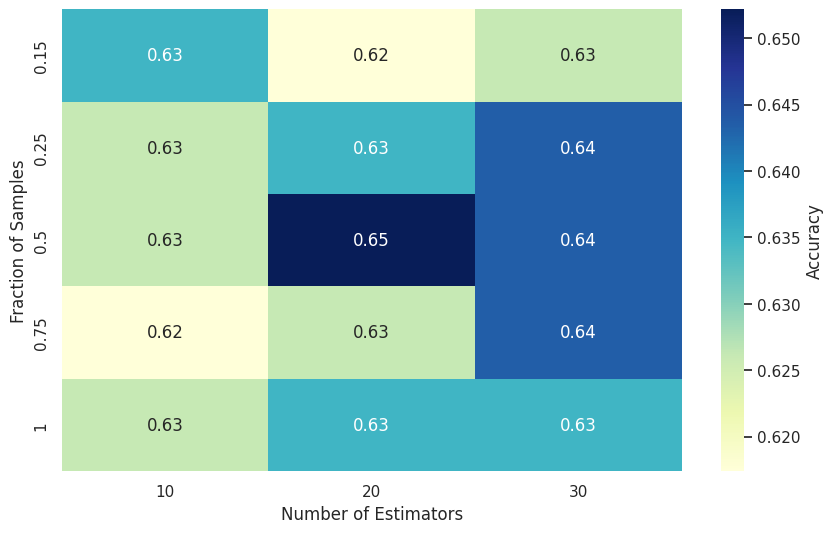

MultiLayerPerceptron


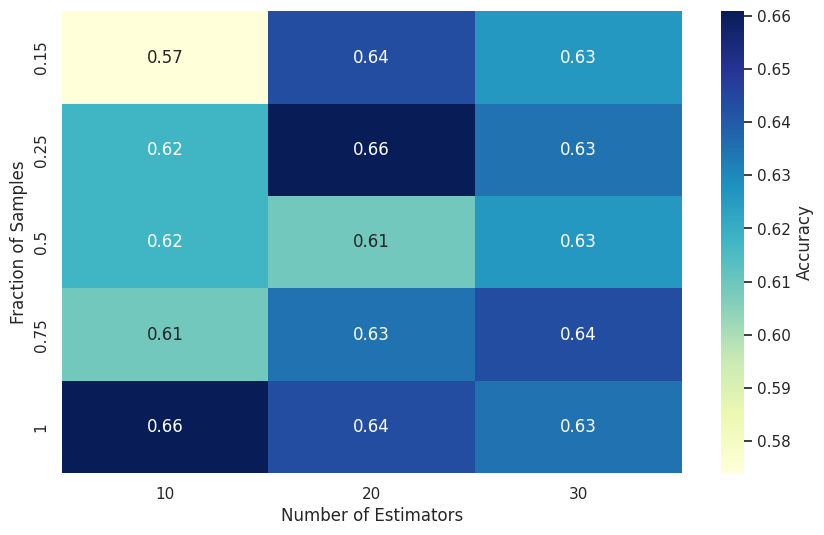

DecisionTree


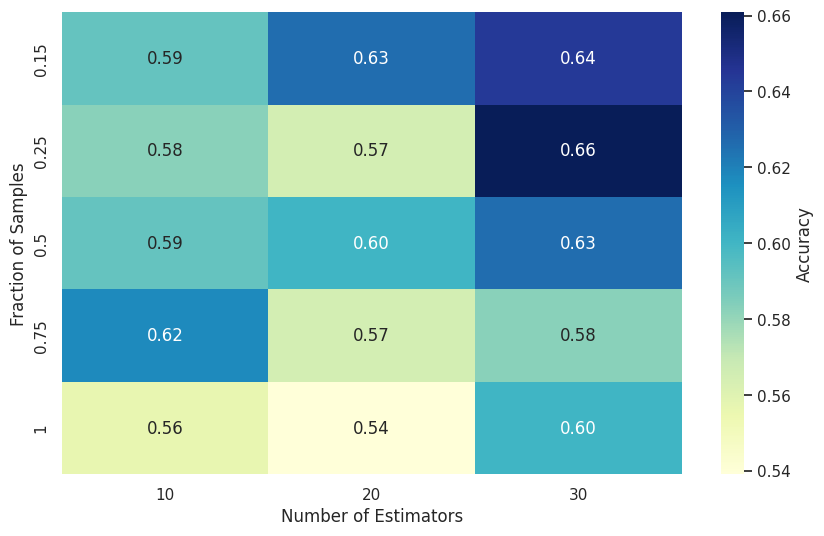

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

base_estimator_models=['LogisticRegression','MultiLayerPerceptron','DecisionTree']
n_estimators=[10,20,30]
fraction_samples=[0.15,0.25,0.50,0.75,1]

for model in base_estimator_models:
    model_accuracies_cl = []
    for fraction_sample in fraction_samples:
        for n_estimator in n_estimators:
            accuracy=accuracies_cl[(model,n_estimator,fraction_sample,True,'soft')]
            model_accuracies_cl.append(accuracy)
    print(model)
    model_accuracies_cl=np.array(model_accuracies_cl)
    model_accuracies_cl=model_accuracies_cl.reshape(5,3)
    sns.set()
    plt.figure(figsize=(10, 6))
    sns.heatmap(model_accuracies_cl, annot=True, fmt=".2f", cmap="YlGnBu",
                xticklabels=n_estimators, yticklabels=fraction_samples, cbar_kws={'label': 'Accuracy'})
    plt.xlabel('Number of Estimators')
    plt.ylabel('Fraction of Samples')
    plt.show()

### Comparing the performance of each model in List 1 models with the best-performing ensemble model of the same class with a single side-by-side histogram

In [45]:
best_hyperparameters_cl_lg=tuple()
best_accuracy_cl_lg=0
best_hyperparameters_cl_mlp=tuple()
best_accuracy_cl_mlp=0
best_hyperparameters_cl_dt=tuple()
best_accuracy_cl_dt=0

base_estimator_models=['LogisticRegression','MultiLayerPerceptron','DecisionTree']
n_estimators=[10,20,30]
fraction_samples=[0.15,0.25,0.5,0.75,1]
bootstraps=[True,False]
votings=['hard','soft']

for n_estimator in n_estimators:
    for fraction_sample in fraction_samples:
        for bootstrap in bootstraps:
            for voting in votings:
                hyperparameters=('LogisticRegression',n_estimator,fraction_sample,bootstrap,voting)
                accuracy=accuracies_cl[hyperparameters]
                if(accuracy>best_accuracy_cl_lg):
                    best_hyperparameters_cl_lg=hyperparameters
                    best_accuracy_cl_lg=accuracy
print('Best Hyperparameters for Logistic Regression :',best_hyperparameters_cl_lg)
print('Accuracy :',best_accuracy_cl_lg)
print('Training Time :',training_time_cl[best_hyperparameters_cl_lg])
print()

for n_estimator in n_estimators:
    for fraction_sample in fraction_samples:
        for bootstrap in bootstraps:
            for voting in votings:
                hyperparameters=('MultiLayerPerceptron',n_estimator,fraction_sample,bootstrap,voting)
                accuracy=accuracies_cl[hyperparameters]
                if(accuracy>best_accuracy_cl_mlp):
                    best_hyperparameters_cl_mlp=hyperparameters
                    best_accuracy_cl_mlp=accuracy
print('Best Hyperparameters for MultiLayerPerceptron :',best_hyperparameters_cl_mlp)
print('Accuracy :',best_accuracy_cl_mlp)
print('Training Time :',training_time_cl[best_hyperparameters_cl_mlp])
print()

for n_estimator in n_estimators:
    for fraction_sample in fraction_samples:
        for bootstrap in bootstraps:
            for voting in votings:
                hyperparameters=('DecisionTree',n_estimator,fraction_sample,bootstrap,voting)
                accuracy=accuracies_cl[hyperparameters]
                if(accuracy>best_accuracy_cl_dt):
                    best_hyperparameters_cl_dt=hyperparameters
                    best_accuracy_cl_dt=accuracy
print('Best Hyperparameters for DecisionTree :',best_hyperparameters_cl_dt)
print('Accuracy :',best_accuracy_cl_dt)
print('Training Time :',training_time_cl[best_hyperparameters_cl_dt])
print()

Best Hyperparameters for Logistic Regression : ('LogisticRegression', 20, 0.5, True, 'soft')
Accuracy : 0.6521739130434783
Training Time : 25.991382837295532

Best Hyperparameters for MultiLayerPerceptron : ('MultiLayerPerceptron', 20, 1, False, 'soft')
Accuracy : 0.6782608695652174
Training Time : 86.49169301986694

Best Hyperparameters for DecisionTree : ('DecisionTree', 10, 0.25, False, 'soft')
Accuracy : 0.6608695652173913
Training Time : 0.023168087005615234



In [46]:
print('Logistic Regression :')
model = MultinomialLogisticRegression(0.01,10000)
model.fit(X_train_cl, y_train_cl)
y_pred = model.predict(X_test_cl)
accuracy_lg=accuracy_score(y_test_cl, y_pred)
print('Accuracy :',accuracy_lg)
print()

print('Multi Layer Perceptron :')
model = MLPClassifier(11,2,10,6,acivationFunction="relu",number_epoch=100,learning_rate=0.001,optimizer="sgd")
model.fit(X_train_cl,y_train_cl)
y_pred=model.predict(X_test_cl)
accuracy_mlp=accuracy_score(y_test_cl, y_pred)
print('Accuracy :',accuracy_mlp)
print()

print('Decision Tree:')
model = DecisionTreeClassifier(criterion=best_criterion_dt_cl,max_depth=best_depth_dt_cl)
model.fit(X_train_cl, y_train_cl)
y_pred = model.predict(X_test_cl)
accuracy_dt=accuracy_score(y_test_cl, y_pred)
print('Accuracy :',accuracy_dt)
print()

Logistic Regression :
Accuracy : 0.6347826086956522

Multi Layer Perceptron :
Accuracy : 0.591304347826087

Decision Tree:
Accuracy : 0.5565217391304348



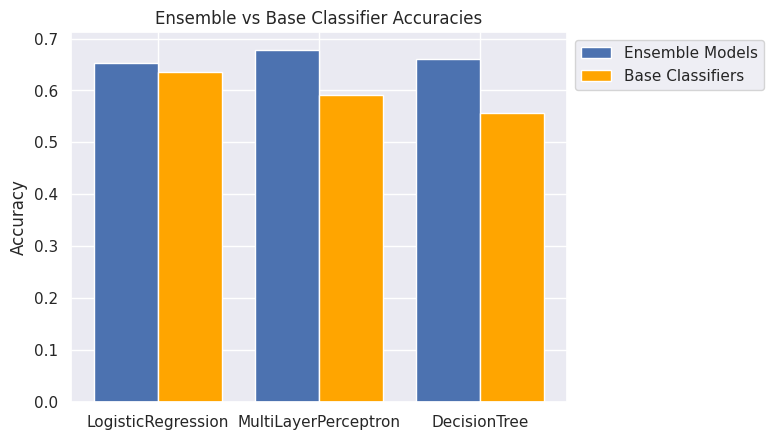

In [47]:
import matplotlib.pyplot as plt

base_estimator_models=['LogisticRegression','MultiLayerPerceptron','DecisionTree']
ensemble_accuracies = [best_accuracy_cl_lg,best_accuracy_cl_mlp,best_accuracy_cl_dt]
base_accuracies = [accuracy_lg,accuracy_mlp,accuracy_dt]

fig, ax = plt.subplots()
ax.bar(np.arange(3), ensemble_accuracies, width=0.4, label="Ensemble Models", align='center')
ax.bar(np.arange(3) + 0.4, base_accuracies, width=0.4, label="Base Classifiers", align='center', color='orange')
ax.set_xticks(np.arange(3) + 0.2)
ax.set_xticklabels(base_estimator_models)
ax.set_ylabel('Accuracy')
ax.set_title('Ensemble vs Base Classifier Accuracies')
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()


# Regression

In [48]:
class MultipleLinearRegression:
    def __init__(self, learning_rate=0.01, num_epochs=1000):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs

    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.coefficients = np.zeros(num_features)
        self.intercept = 0
        
        for i in range(self.num_epochs):
            y_pred = np.dot(X, self.coefficients) + self.intercept
            dw = (1/num_samples) * np.dot(X.T, (y_pred - y))
            db = (1/num_samples) * np.sum(y_pred - y)
            self.coefficients -= self.learning_rate * dw
            self.intercept -= self.learning_rate * db
            mse = self.mean_squared_error(y, y_pred)
            # print(mse)

    def mean_squared_error(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)
    
    def predict(self, X):
        return np.dot(X, self.coefficients) + self.intercept

In [49]:
class MLPRegressor(object):
    def __init__(self, inputLayerSize=2, hiddenLayers=1, hiddenLayerSize=3, outputLayerSize=1,acivationFunction="sigmoid",number_epoch=10000,learning_rate=0.3,optimizer="gd"):
        self.inputLayerSize = inputLayerSize
        self.outputLayerSize = outputLayerSize
        self.hiddenLayers = hiddenLayers
        self.hiddenLayerSize = hiddenLayerSize
        self.activationFunction=acivationFunction
        self.number_epoch=number_epoch
        self.learning_rate=learning_rate
        self.optimizer=optimizer

    def initialize(self):
        self.weights=[]
        self.biases=[]
        self.weights.append(np.random.randn(self.inputLayerSize, self.hiddenLayerSize))
        self.biases.append(np.random.randn(self.hiddenLayerSize))
        for i in range(self.hiddenLayers-1):
            self.weights.append(np.random.randn(self.hiddenLayerSize, self.hiddenLayerSize))
            self.biases.append(np.random.randn(self.hiddenLayerSize))
        self.weights.append(np.random.randn(self.hiddenLayerSize, self.outputLayerSize))
        self.biases.append(np.random.randn(self.outputLayerSize))

    def fit(self,X,y):
        y=y.reshape((len(y),1))
        if self.optimizer=="gd":
            self.gd(X,y)
        if self.optimizer=="mini_gd":
            self.mini_gd(X,y)
        if self.optimizer=="sgd":
            self.sgd(X,y)
    
    def activation(self,z):
        if(self.activationFunction=='sigmoid'):
            return 1 / (1 + np.exp(-z))
        if(self.activationFunction=='relu'):
            return np.maximum(0, z)
        if(self.activationFunction=='tanh'):
            return np.tanh(z)
    
    def activationPrime(self,z):    
        if(self.activationFunction=='sigmoid'):
            return np.exp(-z)/((1 + np.exp(-z))**2)
        if(self.activationFunction=='relu'):
            return (z > 0).astype(int)
        if(self.activationFunction=='tanh'):
            return 1 - np.tanh(z) ** 2

    def forward(self, X):
        self.z=[]
        self.a=[]
        self.z.append(np.dot(X,self.weights[0])+self.biases[0])
        self.a.append(self.activation(self.z[0]))
        for i in range(1,self.hiddenLayers):
            self.z.append(np.dot(self.a[i-1],self.weights[i])+self.biases[i])
            self.a.append(self.activation(self.z[i]))
        self.z.append(np.dot(self.a[self.hiddenLayers-1],self.weights[self.hiddenLayers])+self.biases[self.hiddenLayers])
        self.a.append(self.z[self.hiddenLayers])
        yHat=self.a[self.hiddenLayers]
        return yHat
    
    def predict(self, X):
        yHat=self.forward(X)
        return yHat

    def backward(self,X,y):
        m=len(X)
        yHat=self.forward(X)
        self.delta=[]
        self.gradient_weight=[]
        self.gradient_bias=[]
        self.delta.append(-(y-yHat)/m)
        self.gradient_weight.append(np.dot(self.a[self.hiddenLayers-1].T,self.delta[-1]))
        self.gradient_bias.append(np.sum(self.delta[-1],axis=0))
        for i in range(self.hiddenLayers-1,0,-1):
            delta_i=np.dot(self.delta[-1],self.weights[i+1].T)*self.activationPrime(self.z[i])/m
            self.delta.append(delta_i)
            self.gradient_weight.append(np.dot(self.a[i-1].T,delta_i))
            self.gradient_bias.append(np.sum(self.delta[-1],axis=0))
        delta_i=np.dot(self.delta[-1],self.weights[1].T)*self.activationPrime(self.z[0])/m
        self.delta.append(delta_i)
        self.gradient_weight.append(np.dot(X.T,delta_i))
        self.gradient_bias.append(np.sum(self.delta[-1],axis=0))
        self.gradient_weight.reverse()
        self.gradient_bias.reverse()

    def loss(self, y_pred, y_true):
        m=len(y_pred)
        return 0.5*np.sum((y_true-y_pred)**2)

    def gd(self,X,y):
        self.initialize()
        for i in range (self.number_epoch):
            # print(self.loss(self.forward(X),y))
            self.backward(X,y)
            for j in range(len(self.weights)):
                self.weights[j]-=self.learning_rate*self.gradient_weight[j]
                self.biases[j]-=self.learning_rate*self.gradient_bias[j]

    def sgd(self,X,y):
        self.initialize()
        for j in range(self.number_epoch):
            for i in range(len(X)):
                self.backward(X[i:i+1],y[i:i+1])
                for k in range(len(self.weights)):
                    self.weights[k]-=self.learning_rate*self.gradient_weight[k]
                    self.biases[k]-=self.learning_rate*self.gradient_bias[k]
            # print(self.loss(self.forward(X),y))

    def mini_gd(self,X,y):
        self.initialize()
        batch_size=32
        batches=len(X)//batch_size
        for epoch in range(self.number_epoch):
            for i in range(0,batches,batch_size):
                self.backward(X[i:i+batch_size],y[i:i+batch_size])
                for k in range(len(self.weights)):
                    self.weights[k]-=self.learning_rate*self.gradient_weight[k]
                    self.biases[k]-=self.learning_rate*self.gradient_bias[k]
            # print(self.loss(self.forward(X),y))
    

In [50]:
housing_data = pd.read_csv('HousingData.csv')

housing_data.fillna(housing_data.mean(), inplace=True)

X= housing_data.drop(columns=['MEDV'])
y=housing_data['MEDV']
X=X.to_numpy()
y=y.to_numpy()

# y=y.reshape((len(y),1))

X_train_reg, X_temp_reg, y_train_reg, y_temp_reg = train_test_split(X, y, test_size=0.2)
X_val_reg, X_test_reg, y_val_reg, y_test_reg = train_test_split(X_temp_reg, y_temp_reg, test_size=0.5)

scaler = StandardScaler()
X_train_reg = scaler.fit_transform(X_train_reg)
X_val_reg = scaler.transform(X_val_reg)
X_test_reg = scaler.transform(X_test_reg)

In [51]:
model = MultipleLinearRegression(0.1,1000)
model.fit(X_train_reg, y_train_reg)
y_pred=model.predict(X_test_reg)
print(r2_score(y_test_reg,y_pred))

0.770711489732369


### Hyperparameter Tuning for MultipleLinearRegression

In [52]:
lr=[0.1,0.01,0.001]
epochs=[100,1000,10000]

best_lr_lg_reg=""
best_epoch_lg_reg=""
best_r2_lg=0

for l in lr:
    for e in epochs:
        model = MultipleLinearRegression(learning_rate=l,num_epochs=e)
        model.fit(X_train_reg, y_train_reg)
        y_pred = model.predict(X_test_reg)
        r2 = r2_score(y_test_reg, y_pred)
        if r2>best_r2_lg:
            best_lr_lg_reg=l
            best_epoch_lg_reg=e
            best_r2_lg=r2

print(best_lr_lg_reg,best_epoch_lg_reg,best_r2_lg)

0.1 10000 0.7707255394314096


In [53]:
model = MLPRegressor(13,5,5,1,acivationFunction="sigmoid",number_epoch=1000,learning_rate=0.001,optimizer="sgd")
model.fit(X_train_reg,y_train_reg)
y_pred=model.forward(X_test_reg)
print(r2_score(y_test_reg,y_pred))
print(mean_squared_error(y_test_reg,y_pred))

0.9029411718672891
10.902608835155863


In [54]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor()
regressor.fit(X_train_reg, y_train_reg)
y_pred = regressor.predict(X_test_reg)

mse = mean_squared_error(y_test_reg, y_pred)
print(f"Mean Squared Error: {mse}")
print(r2_score(y_test_reg,y_pred))

Mean Squared Error: 25.472745098039212
0.7732327348508786


### Hyperparameter Tuning for DecisionTreeRegressor

In [55]:
criteria=['squared_error','absolute_error']
depth=[10,20,30]

best_criterion_dt_reg=""
best_depth_dt_reg=""
best_r2_dt=0

for c in criteria:
    for d in depth:
        model = DecisionTreeRegressor(criterion=c,max_depth=d)
        model.fit(X_train_reg, y_train_reg)
        y_pred = model.predict(X_test_reg)
        r2 = r2_score(y_test_reg, y_pred)
        if r2>best_r2_dt:
            best_criterion_dt_reg=c
            best_depth_dt_reg=d
            best_r2_dt=r2

print(best_criterion_dt_reg,best_depth_dt_reg,best_r2_dt)

absolute_error 20 0.8411052904527391


In [56]:
lg_reg_model=MultipleLinearRegression(learning_rate=best_lr_lg_reg,num_epochs=best_epoch_lg_reg)
mlp_reg_model=MLPRegressor(13,5,5,1,acivationFunction="sigmoid",number_epoch=1000,learning_rate=0.001,optimizer="sgd")
dt_reg_model=DecisionTreeRegressor(criterion=best_criterion_dt_reg,max_depth=best_depth_dt_reg)

## BaggingRegressor

In [57]:
class BaggingRegressor:
    def __init__(self, base_estimator_model, n_estimators, sample_fraction, bootstrap=True, voting='hard'):
        self.base_estimator_model = base_estimator_model
        self.n_estimators = n_estimators
        self.sample_fraction = sample_fraction
        self.bootstrap = bootstrap
        self.voting = voting
        self.ensemble_models = []

    def fit(self, X, y):
        self.ensemble_models = []
        for _ in range(self.n_estimators):
            if self.bootstrap:
                indices = np.random.choice(len(X), size=int(self.sample_fraction * len(X)), replace=True)
            else:
                indices = np.random.choice(len(X), size=int(self.sample_fraction * len(X)), replace=False)
            
            sampled_X = X[indices]
            sampled_y = y[indices]

            if(self.base_estimator_model=='DecisionTree'):
                model = DecisionTreeRegressor(criterion=best_criterion_dt_reg,max_depth=best_depth_dt_reg)
            if(self.base_estimator_model=='MultiLayerPerceptron'):
                model = MLPRegressor(13,5,5,1,acivationFunction="sigmoid",number_epoch=1000,learning_rate=0.001,optimizer="sgd")
            if(self.base_estimator_model=='LinearRegression'):
                model = MultipleLinearRegression(learning_rate=best_lr_lg_reg,num_epochs=best_epoch_lg_reg)

            model.fit(sampled_X, sampled_y)
            self.ensemble_models.append(model)

    def predict(self, X):
        if self.voting == 'hard':
            predictions = np.array([model.predict(X) for model in self.ensemble_models])
            y_pred = np.mean(predictions,axis=0)
            return y_pred
        elif self.voting == 'soft':
            weights = np.array([r2_score(y_val_reg,model.predict(X_val_reg)) for model in self.ensemble_models])
            weights/=np.sum(weights)
            predictions = np.array([self.ensemble_models[i].predict(X)*weights[i] for i in range(len(self.ensemble_models))])
            y_pred = np.sum(predictions, axis=0)
            return y_pred

In [58]:
n_estimators = 10
sample_fraction = 0.15
bootstrap = True
voting = 'hard'

bagging_regressor = BaggingRegressor('MultiLayerPerceptron', n_estimators, sample_fraction, bootstrap, voting)
bagging_regressor.fit(X_train_reg, y_train_reg)
y_pred = bagging_regressor.predict(X_test_reg)
print(r2_score(y_test_reg,y_pred))


0.8005748579199848


### Hyperparamter Tuning for BaggingRegressor

In [59]:
from prettytable import PrettyTable
import time

base_estimator_models=['LinearRegression','MultiLayerPerceptron','DecisionTree']
n_estimators=[10,20,30]
fraction_samples=[0.15,0.25,0.5,0.75,1]
bootstraps=[True,False]
votings=['hard','soft']

table_reg = PrettyTable()
table_reg.field_names = ['base_estimator_model','n_estimator','fraction_samples','bootstrap','voting','r2_score']

r2_scores_reg={}
training_time_reg={}
best_hyperparameters_reg=tuple()
best_r2_reg=0
for model in base_estimator_models:
    for n_estimator in n_estimators:
        for fraction_sample in fraction_samples:
            for bootstrap in bootstraps:
                for voting in votings:
                    hyperparameters=(model,n_estimator,fraction_sample,bootstrap,voting)
                    bagging_regressor = BaggingRegressor(model, n_estimator, fraction_sample, bootstrap, voting)
                    start=time.time()
                    bagging_regressor.fit(X_train_reg, y_train_reg)
                    end=time.time()
                    predictions = bagging_regressor.predict(X_test_reg)
                    r2=r2_score(y_test_reg,predictions)
                    if(r2>best_r2_reg):
                        best_hyperparameters_reg=hyperparameters
                        best_r2_reg=r2
                    training_time_reg[hyperparameters]=end-start
                    r2_scores_reg[hyperparameters]=r2
                    table_reg.add_row([model,n_estimator,fraction_sample,bootstrap,voting,r2])
                    print(hyperparameters,r2)

('LinearRegression', 10, 0.15, True, 'hard') 0.7555741285857791


('LinearRegression', 10, 0.15, True, 'soft') 0.7721310241213799
('LinearRegression', 10, 0.15, False, 'hard') 0.7720200779791355
('LinearRegression', 10, 0.15, False, 'soft') 0.762815072301914
('LinearRegression', 10, 0.25, True, 'hard') 0.7649271316821267
('LinearRegression', 10, 0.25, True, 'soft') 0.7406296419823919
('LinearRegression', 10, 0.25, False, 'hard') 0.7668976964070862
('LinearRegression', 10, 0.25, False, 'soft') 0.7658948549700085
('LinearRegression', 10, 0.5, True, 'hard') 0.7649505883126331
('LinearRegression', 10, 0.5, True, 'soft') 0.762231881047179
('LinearRegression', 10, 0.5, False, 'hard') 0.7685179357437285
('LinearRegression', 10, 0.5, False, 'soft') 0.7730968974903107
('LinearRegression', 10, 0.75, True, 'hard') 0.7708739117953903
('LinearRegression', 10, 0.75, True, 'soft') 0.7689546011306336
('LinearRegression', 10, 0.75, False, 'hard') 0.771642491219112
('LinearRegression', 10, 0.75, False, 'soft') 0.7710135977241178
('LinearRegression', 10, 1, True, 'hard

In [60]:
print(table_reg)

+----------------------+-------------+------------------+-----------+--------+--------------------+
| base_estimator_model | n_estimator | fraction_samples | bootstrap | voting |      r2_score      |
+----------------------+-------------+------------------+-----------+--------+--------------------+
|   LinearRegression   |      10     |       0.15       |    True   |  hard  | 0.7555741285857791 |
|   LinearRegression   |      10     |       0.15       |    True   |  soft  | 0.7721310241213799 |
|   LinearRegression   |      10     |       0.15       |   False   |  hard  | 0.7720200779791355 |
|   LinearRegression   |      10     |       0.15       |   False   |  soft  | 0.762815072301914  |
|   LinearRegression   |      10     |       0.25       |    True   |  hard  | 0.7649271316821267 |
|   LinearRegression   |      10     |       0.25       |    True   |  soft  | 0.7406296419823919 |
|   LinearRegression   |      10     |       0.25       |   False   |  hard  | 0.7668976964070862 |


### Best Hyperparamters for BaggingRegressor

In [61]:
print('Best Hyperparameters :',best_hyperparameters_reg)
print('r2_score :',best_r2_reg)

Best Hyperparameters : ('DecisionTree', 30, 0.75, False, 'soft')
r2_score : 0.936955237585639


### Heatmap for the accuracies obtained by each class of base estimator models across Fraction of Samples and Number of Estimators

LinearRegression


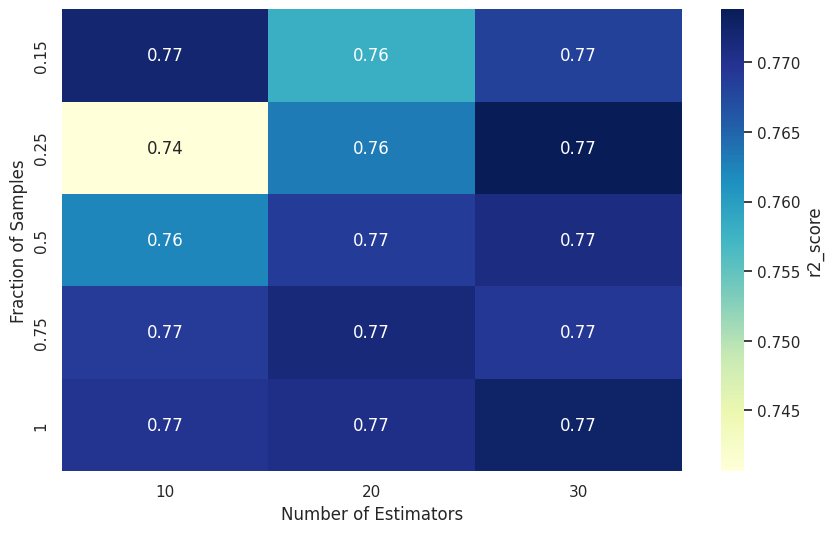

MultiLayerPerceptron


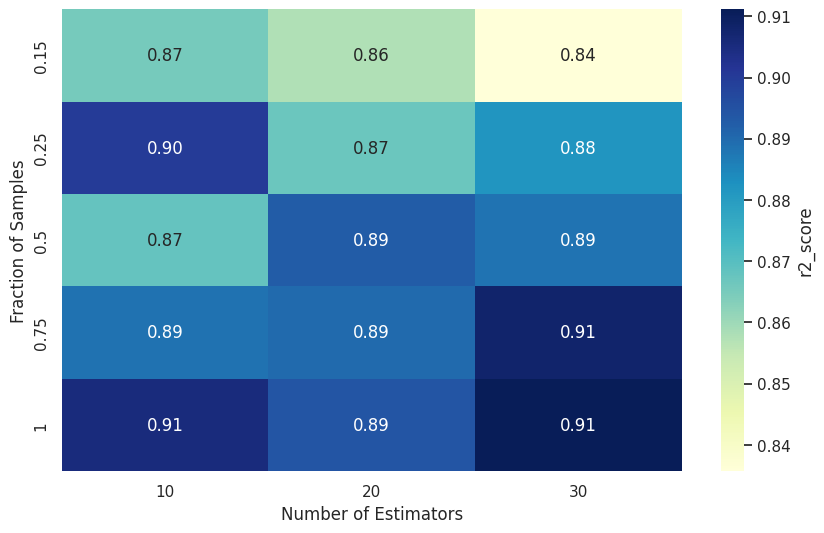

DecisionTree


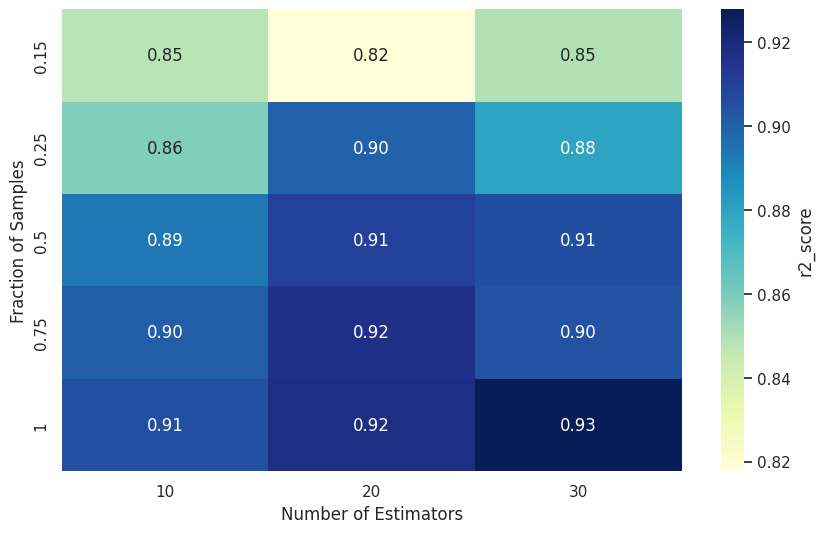

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

base_estimator_models=['LinearRegression','MultiLayerPerceptron','DecisionTree']
n_estimators=[10,20,30]
fraction_samples=[0.15,0.25,0.50,0.75,1]

for model in base_estimator_models:
    model_r2_reg = []
    for fraction_sample in fraction_samples:
        for n_estimator in n_estimators:
            r2=r2_scores_reg[(model,n_estimator,fraction_sample,True,'soft')]
            model_r2_reg.append(r2)
    print(model)
    model_r2_reg=np.array(model_r2_reg)
    model_r2_reg=model_r2_reg.reshape(5,3)
    sns.set()
    plt.figure(figsize=(10, 6))
    sns.heatmap(model_r2_reg, annot=True, fmt=".2f", cmap="YlGnBu",
                xticklabels=n_estimators, yticklabels=fraction_samples, cbar_kws={'label': 'r2_score'})
    plt.xlabel('Number of Estimators')
    plt.ylabel('Fraction of Samples')
    plt.show()

### Comparing the performance of each model in List 1 models with the best-performing ensemble model of the same class with a single side-by-side histogram

In [63]:
best_hyperparameters_reg_lg=tuple()
best_r2_reg_lg=0
best_hyperparameters_reg_mlp=tuple()
best_r2_reg_mlp=0
best_hyperparameters_reg_dt=tuple()
best_r2_reg_dt=0

base_estimator_models=['LinearRegression','MultiLayerPerceptron','DecisionTree']
n_estimators=[10,20,30]
fraction_samples=[0.15,0.25,0.5,0.75,1]
bootstraps=[True,False]
votings=['hard','soft']

for n_estimator in n_estimators:
    for fraction_sample in fraction_samples:
        for bootstrap in bootstraps:
            for voting in votings:
                hyperparameters=('LinearRegression',n_estimator,fraction_sample,bootstrap,voting)
                r2=r2_scores_reg[hyperparameters]
                if(r2>best_r2_reg_lg):
                    best_hyperparameters_reg_lg=hyperparameters
                    best_r2_reg_lg=r2
print('Best Hyperparameters for Linear Regression :',best_hyperparameters_reg_lg)
print('r2_score :',best_r2_reg_lg)
print('Training Time :',training_time_reg[best_hyperparameters_reg_lg])
print()

for n_estimator in n_estimators:
    for fraction_sample in fraction_samples:
        for bootstrap in bootstraps:
            for voting in votings:
                hyperparameters=('MultiLayerPerceptron',n_estimator,fraction_sample,bootstrap,voting)
                r2=r2_scores_reg[hyperparameters]
                if(r2>best_r2_reg_mlp):
                    best_hyperparameters_reg_mlp=hyperparameters
                    best_r2_reg_mlp=r2
print('Best Hyperparameters for MultiLayerPerceptron :',best_hyperparameters_reg_mlp)
print('r2_score :',best_r2_reg_mlp)
print('Training Time :',training_time_reg[best_hyperparameters_reg_mlp])
print()

for n_estimator in n_estimators:
    for fraction_sample in fraction_samples:
        for bootstrap in bootstraps:
            for voting in votings:
                hyperparameters=('DecisionTree',n_estimator,fraction_sample,bootstrap,voting)
                r2=r2_scores_reg[hyperparameters]
                if(r2>best_r2_reg_dt):
                    best_hyperparameters_reg_dt=hyperparameters
                    best_r2_reg_dt=r2
print('Best Hyperparameters for DecisionTree :',best_hyperparameters_reg_dt)
print('r2_score :',best_r2_reg_dt)
print('Training Time :',training_time_reg[best_hyperparameters_reg_dt])
print()

Best Hyperparameters for Linear Regression : ('LinearRegression', 30, 0.25, True, 'soft')
r2_score : 0.7738201720760445
Training Time : 4.10326361656189

Best Hyperparameters for MultiLayerPerceptron : ('MultiLayerPerceptron', 30, 1, False, 'soft')
r2_score : 0.9161783453098199
Training Time : 1216.1621496677399

Best Hyperparameters for DecisionTree : ('DecisionTree', 30, 0.75, False, 'soft')
r2_score : 0.936955237585639
Training Time : 0.2981102466583252



In [64]:
print('Linear Regression :')
model = MultipleLinearRegression(learning_rate=best_lr_lg_reg,num_epochs=best_epoch_lg_reg)
model.fit(X_train_reg, y_train_reg)
y_pred = model.predict(X_test_reg)
r2_lg=r2_score(y_test_reg, y_pred)
print('r2_score :',r2_lg)
print()

print('Multi Layer Perceptron :')
model = MLPRegressor(13,5,5,1,acivationFunction="sigmoid",number_epoch=1000,learning_rate=0.001,optimizer="sgd")
model.fit(X_train_reg,y_train_reg)
y_pred=model.predict(X_test_reg)
r2_mlp=r2_score(y_test_reg, y_pred)
print('r2_score :',r2_mlp)
print()

print('Decision Tree:')
model = DecisionTreeRegressor(criterion=best_criterion_dt_reg,max_depth=best_depth_dt_reg)
model.fit(X_train_reg, y_train_reg)
y_pred = model.predict(X_test_reg)
r2_dt=r2_score(y_test_reg, y_pred)
print('r2_score :',r2_dt)
print()

Linear Regression :
r2_score : 0.7707255394314096

Multi Layer Perceptron :


r2_score : 0.8893958971841542

Decision Tree:
r2_score : 0.8324717575461525



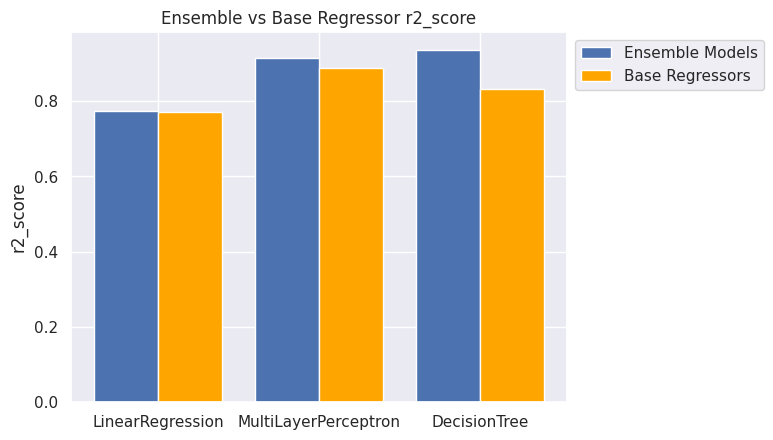

In [65]:
import matplotlib.pyplot as plt

base_estimator_models=['LinearRegression','MultiLayerPerceptron','DecisionTree']
ensemble_r2_scores = [best_r2_reg_lg,best_r2_reg_mlp,best_r2_reg_dt]
base_r2_scores = [r2_lg,r2_mlp,r2_dt]

fig, ax = plt.subplots()
ax.bar(np.arange(3), ensemble_r2_scores, width=0.4, label="Ensemble Models", align='center')
ax.bar(np.arange(3) + 0.4, base_r2_scores, width=0.4, label="Base Regressors", align='center', color='orange')
ax.set_xticks(np.arange(3) + 0.2)
ax.set_xticklabels(base_estimator_models)
ax.set_ylabel('r2_score')
ax.set_title('Ensemble vs Base Regressor r2_score')
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()
